In [1]:
import os
import json
import pandas as pd
import numpy as np
import gymnasium as gym
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

import matplotlib.pyplot as plt

# User defined imports
import tools_RLHF


## **Data Path**

In [2]:
# path_data = "..\\Training\\2025-05-15_22-49-01"
path_data = "..\\Training\\2025-05-20_22-33-13"
path_reward_model = os.path.join(path_data, "RLHF_Reward_net")


In [3]:
# Just for test, not the real training data path
Data_Test = tools_RLHF.Data_Class("..\\trajectory_pairs.csv")
len(Data_Test.traj_reject_list_list_tensor)

Data loaded from:  ..\trajectory_pairs.csv


100

## **Reward Model Training**

In [4]:

# ———— Hyperparameters ————
gamma = 0.99      
lr = 1e-4          
batch_size = 16
num_epochs = 200

# ———— Load Data ————
Data = tools_RLHF.Data_Class(os.path.join(path_data, "RLHF_trajectory_pairs.csv"))

# 自定义 collate_fn，保留变长序列
# Custom collate_fn to keep variable-length sequences
def variable_collate(batch):
    # batch: List of tuples (s_pref, a_pref, s_rej, a_rej)
    s_pf, a_pf, s_rj, a_rj = zip(*batch)
    return list(s_pf), list(a_pf), list(s_rj), list(a_rj)

# ——— Training Preperation ———
dataset = tools_RLHF.PreferenceDataset(
    Data.traj_prefer_list_list_tensor,
    Data.traj_reject_list_list_tensor,
    gamma
)
loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=variable_collate
)

reward_net = tools_RLHF.RewardMLP(Data.dim_state, Data.dim_action, hidden_dim=64) # 实例化 神经网络 MLP
optimizer  = optim.Adam(reward_net.parameters(), lr=lr)
loss_fn    = nn.BCEWithLogitsLoss()

# ——— Training Loop ———
for epoch in range(1, num_epochs + 1):
    total_loss = 0.0
    for s_pref_list, a_pref_list, s_rej_list, a_rej_list in loader:
        R_pref_batch = []
        R_rej_batch  = []

        # 计算 prefer 轨迹的回报
        # Calculate the return for preferred trajectories
        for s_pf, a_pf in zip(s_pref_list, a_pref_list):
            r_pf = reward_net(s_pf, a_pf)           # [L_i]
            discounts = torch.tensor([gamma**t for t in range(r_pf.size(0))], device=r_pf.device)
            R_pref_batch.append((r_pf * discounts).sum())

        # 计算 reject 轨迹的回报
        # Calculate the return for rejected trajectories
        for s_rj, a_rj in zip(s_rej_list, a_rej_list):
            r_rj = reward_net(s_rj, a_rj)          # [L_j]
            discounts = torch.tensor([gamma**t for t in range(r_rj.size(0))], device=r_rj.device)
            R_rej_batch.append((r_rj * discounts).sum())

        R_pref = torch.stack(R_pref_batch)
        R_rej = torch.stack(R_rej_batch)

        logits = R_pref - R_rej
        targets = torch.ones_like(logits)        
        loss = loss_fn(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(R_pref_batch)

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch}/{num_epochs} — Avg Loss: {avg_loss:.4f}")

# ——— Save Model ———
path_reward_model = os.path.join(path_data, "RLHF_Reward_net")
torch.save(reward_net.state_dict(), path_reward_model)
print("🎉 Model has been saved to:", path_reward_model)


Data loaded from:  ..\Training\2025-05-20_22-33-13\RLHF_trajectory_pairs.csv
Epoch 1/200 — Avg Loss: 2.7934
Epoch 2/200 — Avg Loss: 2.1838
Epoch 3/200 — Avg Loss: 1.6015
Epoch 4/200 — Avg Loss: 1.1200
Epoch 5/200 — Avg Loss: 0.7557
Epoch 6/200 — Avg Loss: 0.5134
Epoch 7/200 — Avg Loss: 0.3636
Epoch 8/200 — Avg Loss: 0.2702
Epoch 9/200 — Avg Loss: 0.2106
Epoch 10/200 — Avg Loss: 0.1734
Epoch 11/200 — Avg Loss: 0.1456
Epoch 12/200 — Avg Loss: 0.1259
Epoch 13/200 — Avg Loss: 0.1105
Epoch 14/200 — Avg Loss: 0.0986
Epoch 15/200 — Avg Loss: 0.0894
Epoch 16/200 — Avg Loss: 0.0819
Epoch 17/200 — Avg Loss: 0.0758
Epoch 18/200 — Avg Loss: 0.0704
Epoch 19/200 — Avg Loss: 0.0655
Epoch 20/200 — Avg Loss: 0.0614
Epoch 21/200 — Avg Loss: 0.0577
Epoch 22/200 — Avg Loss: 0.0543
Epoch 23/200 — Avg Loss: 0.0513
Epoch 24/200 — Avg Loss: 0.0488
Epoch 25/200 — Avg Loss: 0.0462
Epoch 26/200 — Avg Loss: 0.0441
Epoch 27/200 — Avg Loss: 0.0420
Epoch 28/200 — Avg Loss: 0.0402
Epoch 29/200 — Avg Loss: 0.0386
Epoc

## **Reward Model Testing**
Load `trajectory_pairs.csv` to see if the total reward matches what the `MLP reward model` predicts

In [5]:
# ——— Load MLP Reward Model ———
reward_net_loaded = tools_RLHF.RewardMLP(Data.dim_state, Data.dim_action, hidden_dim=64)
reward_net_loaded.load_state_dict(torch.load(path_reward_model, weights_only=True))
reward_net_loaded.eval()

# Load .csv Data
for i in range(10):
    traj_prefer_json = Data.trajs_prefer_list.get_single_traj_json(i)
    traj_reject_json = Data.trajs_reject_list.get_single_traj_json(i)

    # convert to tensor
    states_prefer  = torch.stack([torch.from_numpy(np.array(step['state'])).float().view(-1)
                                  for step in traj_prefer_json], dim=0)    # [L, s_dim]
    actions_prefer = torch.stack([torch.from_numpy(np.array(step['action'])).float().view(-1)
                                    for step in traj_prefer_json], dim=0)  # [L, a_dim]
    states_reject  = torch.stack([torch.from_numpy(np.array(step['state'])).float().view(-1)
                                    for step in traj_reject_json], dim=0)  # [L, s_dim]
    actions_reject = torch.stack([torch.from_numpy(np.array(step['action'])).float().view(-1)
                                    for step in traj_reject_json], dim=0)  # [L, a_dim]

    # 计算 prefer 轨迹的回报
    # Calculate the return for preferred trajectories
    with torch.no_grad():
        r_pref = reward_net_loaded(states_prefer, actions_prefer)          

    # 计算总回报
    # Calculate total return
    discounts = torch.tensor([gamma**t for t in range(r_pref.size(0))])
    total_return_prefer = (r_pref * discounts).sum()

    # 计算 reject 轨迹的回报
    # Calculate the return for rejected trajectories
    with torch.no_grad():
        r_rj = reward_net_loaded(states_reject, actions_reject)          

    # 计算总回报
    # Calculate total return
    discounts = torch.tensor([gamma**t for t in range(r_rj.size(0))])
    total_return_reject = (r_rj * discounts).sum()

    print(i, total_return_prefer, total_return_reject)



0 tensor(18.8158) tensor(12.9562)
1 tensor(19.3714) tensor(9.4387)
2 tensor(19.8860) tensor(9.4713)
3 tensor(15.8373) tensor(10.1113)
4 tensor(18.9704) tensor(4.8008)
5 tensor(19.1611) tensor(16.7561)
6 tensor(19.7023) tensor(7.8766)
7 tensor(19.2357) tensor(9.7910)
8 tensor(19.0535) tensor(3.5297)
9 tensor(19.6320) tensor(12.0497)


In [6]:
Data = tools_RLHF.Data_Class(os.path.join(path_data, "RLHF_trajectory_pairs.csv"))
for i in range(10):
    print(i, len(Data.trajs_prefer_list.get_single_traj_json(i)), len(Data.trajs_reject_list.get_single_traj_json(i)))

Data loaded from:  ..\Training\2025-05-20_22-33-13\RLHF_trajectory_pairs.csv
0 500 176
1 500 148
2 500 75
3 199 85
4 500 34
5 500 290
6 500 100
7 500 74
8 500 20
9 500 115


## **PPO-RLHF Training**

In [ ]:
# # --------------------------------------------------------------------------------------------------
# # 2. 定义一个 Wrapper，在 step 里用你的 MLP 计算 reward
# # 2. Define a Wrapper that uses your MLP to calculate the reward in step
# # --------------------------------------------------------------------------------------------------
# class CustomRewardWrapper(gym.Wrapper):
#     def __init__(self, env, reward_model_path, device="cpu"):
#         super().__init__(env)

#         # state dimension
#         self.dim_state = env.observation_space.shape[0]

#         # action dimension
#         try:                  self.dim_action = env.action_space.shape[0]
#         except IndexError:    self.dim_action = 1

#         self.device = device

#         # Ensure the input dimensions match the checkpoint
#         checkpoint = torch.load(reward_model_path, map_location=device, weights_only=False)
#         input_dim = checkpoint['net.0.weight'].size(1)  # Extract input size from checkpoint
#         self.reward_model = tools_RLHF.RewardMLP(input_dim - self.dim_action, self.dim_action).to(device)
#         self.reward_model.load_state_dict(checkpoint)
#         self.reward_model.load_state_dict(torch.load(reward_model_path, map_location=device, weights_only=False))
#         self.reward_model.eval()
    
#     def step(self, action):
#         # 执行原 env，不用原 reward
#         # Execute the original env, without the original reward
#         obs, _, terminated, truncated, info = self.env.step(action)   
        
#         state_tensor = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)

#         if isinstance(self.env.action_space, gym.spaces.Discrete):
#             action_tensor = torch.tensor([action], dtype=torch.long, device=self.device)
#         else:
#             action_tensor = torch.tensor(action, dtype=torch.float32, device=self.device).unsqueeze(0)

#         # 修改 action_tensor 形状
#         # Modify action_tensor shape
#         if action_tensor.ndim == 1:
#             action_tensor = action_tensor.view(1, -1)

#         # 计算奖励  
#         # Calculate reward
#         with torch.no_grad():
#             reward_tensor = self.reward_model(state_tensor, 
#                                               action_tensor)
#         reward = reward_tensor.item()
#         return obs, reward, terminated, truncated, info
    
# def reset(self, **kwargs):
#     return self.env.reset(**kwargs)

# # Log path
# current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# log_path = os.path.join(path_data, "Training PPO-RLHF", current_time)
# os.makedirs(log_path, exist_ok=True)

# # Reward Model path
# MODEL_PATH = path_reward_model

# print("Reward Model Path:", MODEL_PATH)


# # --------------------------------------------------------------------------------------------------
# # 3. 构造 vectorized 环境，并应用自定义 Wrapper
# # 3. Construct vectorized environment and apply custom Wrapper
# # --------------------------------------------------------------------------------------------------

# #### Build env
# vec_env = make_vec_env(
#     env_id="CartPole-v1",
#     n_envs=8,
#     wrapper_class=lambda env: CustomRewardWrapper(env, MODEL_PATH, device="cpu"),
#     monitor_dir=log_path
# )

# # vec_env = VecMonitor(vec_env, log_path)


# #### Build PPO Model
# model = PPO(
#     policy="MlpPolicy",
#     env=vec_env,
#     n_steps=256,
#     device="cpu",
#     verbose=1,
#     tensorboard_log=log_path
# )

# #### Training
# model.learn( 
#     total_timesteps=50000,
#     # callback=[eval_callback, save_callback]
# )

# #### Save Model
# model.save(os.path.join(log_path, "model_full_training_RLHF"))

Reward Model Path: ..\Training\2025-05-20_22-33-13\RLHF_Reward_net
Using cpu device
Logging to ..\Training\2025-05-20_22-33-13\Training PPO-RLHF\2025-05-20_23-02-42\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 20.8     |
| time/              |          |
|    fps             | 3081     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 22          |
|    ep_rew_mean          | 22          |
| time/                   |             |
|    fps                  | 1419        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017338866 |
|    clip_fraction        |

## **PPO-RLHF Fine-tune**

In [8]:
# --------------------------------------------------------------------------------------------------
# 2. 定义一个 Wrapper，在 step 里用你的 MLP 计算 reward
# 2. Define a Wrapper that uses your MLP to calculate the reward in step
# --------------------------------------------------------------------------------------------------
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env, reward_model_path, device="cpu"):
        super().__init__(env)

        # state dimension
        self.dim_state = env.observation_space.shape[0]

        # action dimension
        try:                  self.dim_action = env.action_space.shape[0]
        except IndexError:    self.dim_action = 1

        self.device = device

        # Ensure the input dimensions match the checkpoint
        checkpoint = torch.load(reward_model_path, map_location=device, weights_only=False)
        input_dim = checkpoint['net.0.weight'].size(1)  # Extract input size from checkpoint
        self.reward_model = tools_RLHF.RewardMLP(input_dim - self.dim_action, self.dim_action).to(device)
        self.reward_model.load_state_dict(checkpoint)
        self.reward_model.load_state_dict(torch.load(reward_model_path, map_location=device, weights_only=False))
        self.reward_model.eval()
    
    def step(self, action):
        # 执行原 env，不用原 reward
        # Execute the original env, without the original reward
        obs, _, terminated, truncated, info = self.env.step(action)   
        
        state_tensor = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)

        if isinstance(self.env.action_space, gym.spaces.Discrete):
            action_tensor = torch.tensor([action], dtype=torch.long, device=self.device)
        else:
            action_tensor = torch.tensor(action, dtype=torch.float32, device=self.device).unsqueeze(0)

        # 修改 action_tensor 形状
        # Modify action_tensor shape
        if action_tensor.ndim == 1:
            action_tensor = action_tensor.view(1, -1)

        # 计算奖励  
        # Calculate reward
        with torch.no_grad():
            reward_tensor = self.reward_model(state_tensor, 
                                              action_tensor)
        reward = reward_tensor.item()
        return obs, reward, terminated, truncated, info
    
def reset(self, **kwargs):
    return self.env.reset(**kwargs)

############################ 路径 ############################

# Log path
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_path = os.path.join(path_data, "PPO_RLHF_Training", current_time)
os.makedirs(log_path, exist_ok=True)

# Reward Model path
MODEL_PATH = path_reward_model

print("Reward Model Path:", MODEL_PATH)


############################ 开始训练 ############################
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

# 1. 加载已有 PPO 模型
pretrained_model_path = os.path.join(path_data, "Pi-2.zip")

# 构造环境
vec_env = make_vec_env(
    env_id="CartPole-v1",
    n_envs=8,
    wrapper_class=lambda env: CustomRewardWrapper(env, MODEL_PATH, device="cpu"),
)

# 加载模型并绑定新环境
model = PPO.load(pretrained_model_path, env=vec_env, device="cpu", tensorboard_log=log_path, verbose=1)

# 2. 定义 KL 散度 Callback
import torch
import torch.nn.functional as F

class KLCoeffCallback(BaseCallback):
    def __init__(self, old_model, kl_coef=0.1, verbose=0):
        super().__init__(verbose)
        self.old_model = old_model
        self.kl_coef = kl_coef

    def _on_rollout_end(self) -> None:
        rollout_buffer = self.model.rollout_buffer
        obs = rollout_buffer.observations
        obs = obs.reshape(-1, *obs.shape[2:])
        if not torch.is_tensor(obs):
            obs = torch.as_tensor(obs, dtype=torch.float32, device=self.model.device)
        # 当前策略 logits/probs
        new_dist = self.model.policy.get_distribution(obs)
        old_dist = self.old_model.policy.get_distribution(obs)
        # 对于离散动作空间，手动计算 KL
        # new_dist.distribution.probs: [batch, n_actions]
        # old_dist.distribution.probs: [batch, n_actions]
        new_probs = new_dist.distribution.probs
        old_probs = old_dist.distribution.probs
        # 避免 log(0)
        eps = 1e-8
        kl = (old_probs * (old_probs.add(eps).log() - new_probs.add(eps).log())).sum(dim=1).mean()
        self.logger.record("train/kl_divergence", kl.item())
        if kl > 0.2:
            print(f"KL divergence too high: {kl.item():.4f}")

    def _on_step(self) -> bool:
        return True
    
    
# 复制一份旧策略用于 KL 约束
old_model = PPO.load(pretrained_model_path, env=vec_env, device="cpu")

kl_callback = KLCoeffCallback(old_model, kl_coef=0.1)

# 3. Fine-tune
model.learn(
    total_timesteps=50000,
    callback=kl_callback
)

# 保存 fine-tune 后的模型
model.save(os.path.join(log_path, os.pardir, os.pardir, "Pi-2-RLHF"))

Reward Model Path: ..\Training\2025-05-20_22-33-13\RLHF_Reward_net
Logging to ..\Training\2025-05-20_22-33-13\PPO_RLHF_Training\2025-05-20_23-03-32\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 88.1     |
|    ep_rew_mean     | 88.1     |
| time/              |          |
|    fps             | 3254     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
| train/             |          |
|    kl_divergence   | 0        |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 121        |
|    ep_rew_mean          | 121        |
| time/                   |            |
|    fps                  | 1606       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 

In [9]:
# from PPO_Original import tools
# print("Plotting path is: ", log_path)
# tools.plot_result(dirs=[log_path],
#                   window = 100)

## **PPO-RLHF Testing**
You can find record video in `Training\2025-xx-xx\video`  
你可以在这个位置找到录像 `Training\2025-xx-xx\video`

In [10]:
import os
import sys
cur_dir = os.getcwd()
pkg_dir = os.path.dirname(cur_dir)
if pkg_dir not in sys.path:
    sys.path.append(pkg_dir)
from PPO_Original import tools
import tools_RLHF
import torch
import numpy as np
import matplotlib.pyplot as plt


# log_path = "..\\Training\\2025-05-15_22-49-01\\Training PPO-RLHF\\2025-05-15_23-23-19"
# path_reward_model = "..\\Training\\2025-05-15_22-49-01\\RLHF_Reward_net"

# PPO-RLHF model testing
PPO_Model_Path = os.path.join(log_path, os.pardir, os.pardir, "Pi-2-RLHF")
tools.test_model("PPO", PPO_Model_Path, n_episodes=2, render = True, record=True)

..\Training\2025-05-20_22-33-13\PPO_RLHF_Training\2025-05-20_23-03-32\..\..\Pi-2-RLHF



c:\Users\MATH-286-Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at d:\EPFL\Course\MA2\[EE-568] Reinforcement Learning\EE-568-RL\Training\2025-05-20_22-33-13\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode: 1 Score: 500.0
Episode: 2 Score: 500.0


Data loaded from:  ..\Training\2025-05-20_22-33-13\RLHF_trajectory_pairs.csv


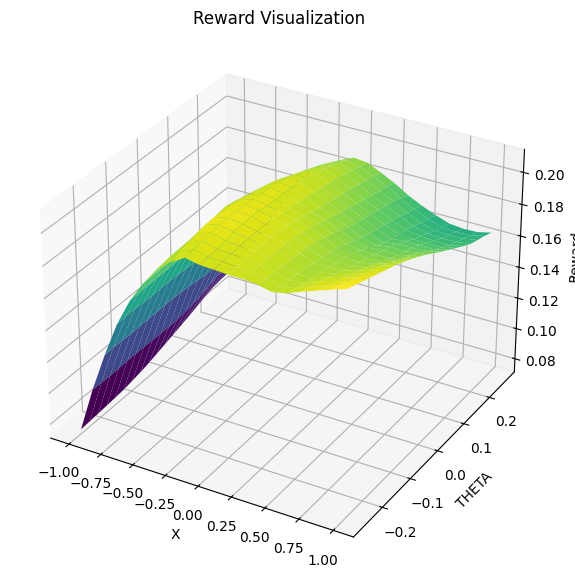

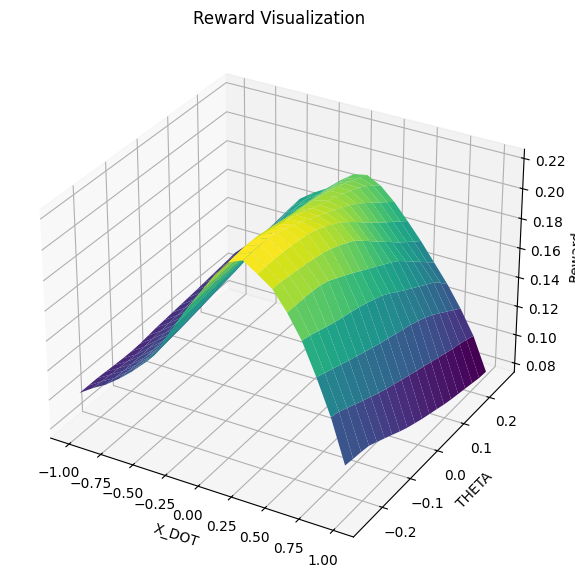

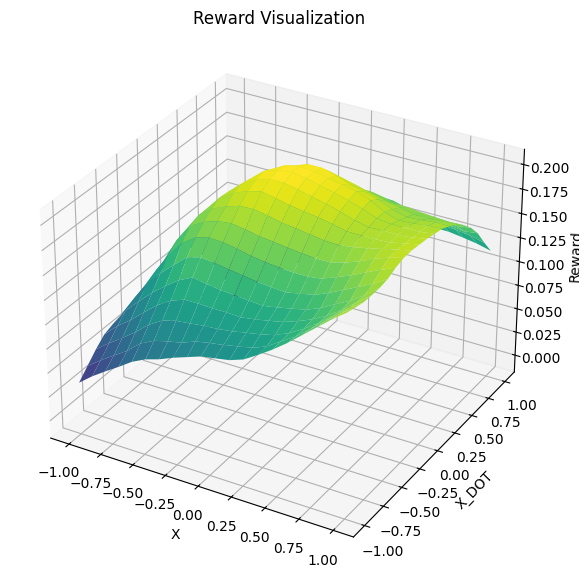

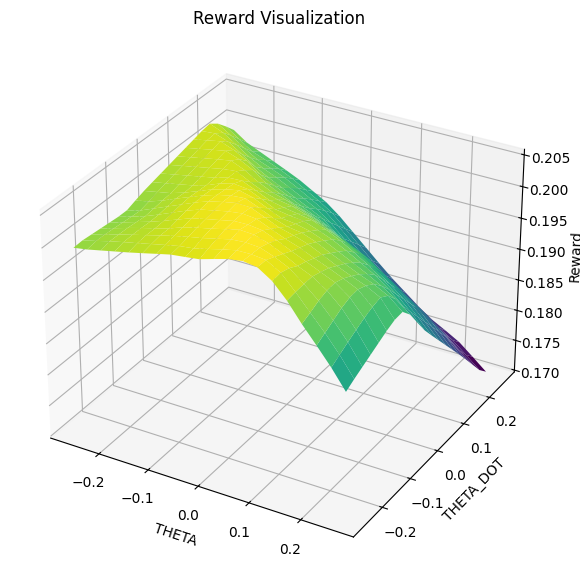

In [12]:
Label_list = [
    'X',
    'X_DOT',
    'THETA',
    'THETA_DOT'
]

def visualize_reward(reward_net, state1_range, state1_index, state2_range, state2_index):
    """
    Visualize the reward function for given state ranges and indices.

    Parameters:
    - reward_net: The reward network to evaluate.
    - state1_range: The range of values for the first state dimension.
    - state1_index: The index of the first state dimension.
    - state2_range: The range of values for the second state dimension.
    - state2_index: The index of the second state dimension.
    """
    # Create data points
    state_1_grid, state_2_grid = torch.meshgrid(state1_range, state2_range, indexing='ij')
    reward_values = torch.zeros_like(state_1_grid)

    # Compute reward
    for i in range(state_1_grid.shape[0]):
        for j in range(state_1_grid.shape[1]):
            # Construct state and action
            state = torch.zeros(Data.dim_state)
            state[state1_index] = state_1_grid[i, j]
            state[state2_index] = state_2_grid[i, j]
            action = torch.zeros(Data.dim_action)

            # Compute reward
            with torch.no_grad():
                reward_values[i, j] = reward_net(state.view(1, -1), action.view(1, -1))

    # Plot 3D graph
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(state_1_grid.numpy(), state_2_grid.numpy(), reward_values.numpy(), cmap='viridis')
    x_label = Label_list[state1_index]
    y_label = Label_list[state2_index]
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel('Reward')
    ax.set_title('Reward Visualization')
    plt.show()


X         = 0
X_DOT     = 1
THETA     = 2
THETA_DOT = 3
GRID_SIZE = 20

# ———— Load Data ————
Data = tools_RLHF.Data_Class(os.path.join(path_data, "RLHF_trajectory_pairs.csv"))

# ——— Load MLP Reward Model ———
reward_net_loaded = tools_RLHF.RewardMLP(Data.dim_state, Data.dim_action, hidden_dim=64)
reward_net_loaded.load_state_dict(torch.load(path_reward_model, weights_only=True))
reward_net_loaded.eval()

visualize_reward(reward_net_loaded,
                  state1_range=torch.linspace(-1, 1, GRID_SIZE),
                  state1_index=X,
                  state2_range=torch.linspace(-np.deg2rad(15), +np.deg2rad(15), GRID_SIZE),
                  state2_index=THETA)

visualize_reward(reward_net_loaded,
                  state1_range=torch.linspace(-1, 1, GRID_SIZE),
                  state1_index=X_DOT,
                  state2_range=torch.linspace(-np.deg2rad(15), +np.deg2rad(15), GRID_SIZE),
                  state2_index=THETA)

visualize_reward(reward_net_loaded,
                  state1_range=torch.linspace(-1, 1, GRID_SIZE),
                  state1_index=X,
                  state2_range=torch.linspace(-1, 1, GRID_SIZE),
                  state2_index=X_DOT)

visualize_reward(reward_net_loaded,
                  state1_range=torch.linspace(-np.deg2rad(15), +np.deg2rad(15), GRID_SIZE),
                  state1_index=THETA,
                  state2_range=torch.linspace(-np.deg2rad(15), +np.deg2rad(15), GRID_SIZE),
                  state2_index=THETA_DOT)

## **Compare Model Performance**